In [ ]:

import tensorflow as tf
import tensorflow_datasets as tfds

#Descargar set de datos de MNIST (Numeros escritos a mano, etiquetados)
datos, metadatos = tfds.load('mnist', as_supervised=True, with_info=True)

#Obtener en variables separadas los datos de entrenamiento (600000) y pruebas (100000)
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']
#Funcion de normalizacion para los datos (Pasar valor de los pixeles de 0-255 a 0-1)
#La red aprende mejor y mas rapido
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 #Aqui se pasa de 0-255 a 0-1
  return imagenes, etiquetas

#Normalizar los datos de entrenamiento con la funcion que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#Agregar a cache (usar memoria en lugar de disco, entrenamiento mas rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

clases = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


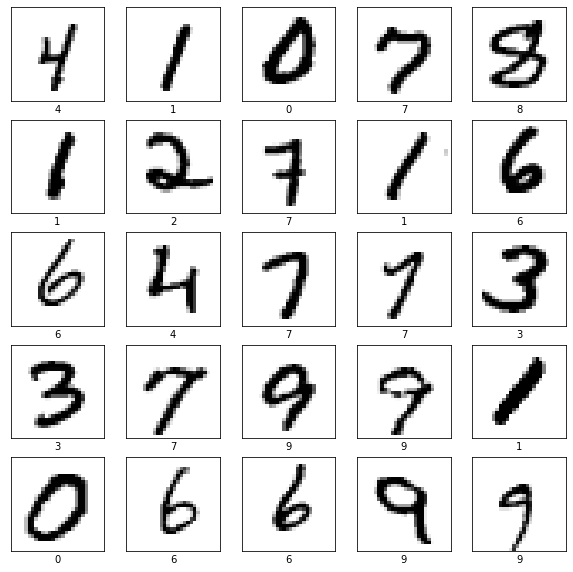

In [ ]:
#Codigo para mostrar imagenes del set
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(clases[etiqueta])

plt.show()  

In [ ]:
#Crear el modelo 
#Cuenta con 1 capa de convolución con 32 núcleos y otra con 64. 2 capas de agrupación.
#Finalmente una capa densa con 100 neuronas
modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(28,28,1), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), #2,2 es el tamano de la matriz

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), #2,2 es el tamano de la matriz

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

#Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
#Los numeros de datos de entrenamiento y pruebas (60000 y 10000)
num_datos_entrenamiento = metadatos.splits["train"].num_examples
num_datos_pruebas = metadatos.splits["test"].num_examples

#Trabajar por lotes
TAMANO_LOTE=32

#Mezclar los datos de entrenamiento para que el modelo no aprenda el orden
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_datos_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)


In [ ]:
#Realizar el entrenamiento
import math

historial = modelo.fit(
    datos_entrenamiento,
    epochs=60,
    steps_per_epoch=math.ceil(num_datos_entrenamiento/TAMANO_LOTE)
)

Epoch 1/60


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1875/1875 [==============================] - 29s 6ms/step - loss: 0.1277 - accuracy: 0.9604
Epoch 2/60
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0410 - accuracy: 0.9872
Epoch 3/60
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0287 - accuracy: 0.9907
Epoch 4/60
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0213 - accuracy: 0.9929
Epoch 5/60
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0166 - accuracy: 0.9950
Epoch 6/60
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0139 - accuracy: 0.9952
Epoch 7/60
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0109 - accuracy: 0.9963
Epoch 8/60
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0084 - accuracy: 0.9970
Epoch 9/60
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0084 - accuracy: 0.9970
Epoch 10/60
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0059

In [38]:
score = modelo.evaluate(datos_pruebas, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.0935392677783966
Test accuracy: 0.991599977016449


In [ ]:
modelo.save('clasificador_de_imagenes.h5')

#Convertirlo a tensorflow.js
!pip install tensorflowjs

!mkdir output

!tensorflowjs_converter --input_format keras clasificador_de_imagenes.h5 output/


     |████████████████████████████████| 77 kB 2.9 MB/s 
     |████████████████████████████████| 462 kB 10.7 MB/s 
